In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [60]:
%matplotlib inline

from typing import List, Optional, Callable

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import itertools
import logging
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import xgboost as xgb

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler, QuantileTransformer, StandardScaler
from sklearn.neighbors import NearestNeighbors
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

from nf.flows import *
from nf.models import NormalizingFlowModel
import matplotlib.pyplot as plt
from rich_utils.my_roc_auc import my_roc_auc

In [3]:
! ls ../data/data_calibsample

kaon2_+_down_2016_.csv	muon_+_down_2016_.csv	pion_+_down_2016_.csv
kaon2_+_up_2016_.csv	muon_+_up_2016_.csv	pion_+_up_2016_.csv
kaon2_-_down_2016_.csv	muon_-_down_2016_.csv	pion_-_down_2016_.csv
kaon2_-_up_2016_.csv	muon_-_up_2016_.csv	pion_-_up_2016_.csv
kaon_+_down_2016_.csv	pion2_+_down_2016_.csv	proton_+_down_2016_.csv
kaon_+_up_2016_.csv	pion2_+_up_2016_.csv	proton_+_up_2016_.csv
kaon_-_down_2016_.csv	pion2_-_down_2016_.csv	proton_-_down_2016_.csv
kaon_-_up_2016_.csv	pion2_-_up_2016_.csv	proton_-_up_2016_.csv


In [62]:
device = 'cuda'
batch_size = 2 * 10**5
data_dir = '../data/data_calibsample'
particle = 'muon'
weight_filed = 'probe_sWeight'
features = ['Brunel_P', 'Brunel_ETA', 'nTracks_Brunel']
dlls = ['RichDLLp', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLbt']
fields = [weight_filed] + features + dlls

params = dict(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1,
    min_child_weight=50,
    n_jobs=24
)

In [5]:
data = pd.concat([
    pd.read_csv(os.path.join(data_dir, f), sep='\t')[fields]
    for f in os.listdir(data_dir) if particle in f
]).sample(frac=1)
data.head()

,probe_sWeight,Brunel_P,Brunel_ETA,nTracks_Brunel,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt
29532,-0.338050,8637.89,3.46837,276,-22.1571,-26.53950,-11.92090,-22.1571,-22.1571
338669,-0.373989,7310.49,2.43705,160,15.6643,-14.36260,-7.27338,15.6643,15.6643
295145,1.251240,6459.14,2.14301,120,-19.1116,-13.46110,20.10820,-19.1116,-19.1116
162656,-0.373901,5462.72,2.75151,248,-18.0955,-31.94940,-15.40090,-18.0955,-18.0955
271090,0.391518,10994.20,3.60248,423,12.3240,-8.81661,-1.69440,10.8282,12.3240


In [6]:
data = data[data.RichDLLe > -998]
data = data[data.RichDLLp != 0.0]
data.shape

(1984209, 9)

In [7]:
X, Y, weights = data[features].values.astype(np.float32), data[dlls].values.astype(np.float32), data[weight_filed].values.astype(np.float32)
train_size = data.shape[0] * 7 // 10

X_train_, Y_train_, w_train = X[: train_size], Y[: train_size], weights[: train_size]
X_val_, Y_val_, w_val = X[train_size :], Y[train_size :], weights[train_size :]
X_train_.shape, X_val_.shape

((1388946, 3), (595263, 3))

In [8]:
class DataPreprocessor:
    def __init__(self):
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

    def fit(self, X, Y):
        self.y_scaler.fit(Y)
        self.x_scaler.fit(np.log(X + 1))
        return self
    
    def transform(self, X, Y):
        return self.x_scaler.transform(np.log(X + 1)), self.y_scaler.transform(Y)
    
    def inverse_transform(self, X, Y):
        return np.exp(self.x_scaler.inverse_transform(X)) - 1, self.y_scaler.inverse_transform(Y)

In [9]:
preprocessor = DataPreprocessor().fit(X_train_, Y_train_)
X_train, Y_train = preprocessor.transform(X_train_, Y_train_)
X_val, Y_val = preprocessor.transform(X_val_, Y_val_)

In [10]:
X_train_tensor = torch.from_numpy(X_train.astype(np.float32)).to(device)
X_test_tensor = torch.from_numpy(X_val.astype(np.float32)).to(device)
Y_train_tensor = torch.from_numpy(Y_train.astype(np.float32)).to(device)
Y_test_tensor = torch.from_numpy(Y_val.astype(np.float32)).to(device)

In [11]:
def get_data_generator(X, Y, batch_size):
    assert(len(X) == len(Y))
    while True:
        for i in range(0, len(X), batch_size):
            yield (Y[i: i + batch_size], X[i: i + batch_size])

data_gen = get_data_generator(X_train_tensor, Y_train_tensor, batch_size)

In [29]:
class ConditionalNormalizingFlowModel(nn.Module):

    def __init__(self, dim, condition_dim, prior, flows, mu=FCNN, log_sigma=FCNN, hidden_dim=8):
        super().__init__()
        self.dim = dim
        self.condition_dim = condition_dim
        self.prior = prior
        self.flows = nn.ModuleList(flows)
        self.mu = mu(condition_dim, dim, hidden_dim)
        self.log_sigma = log_sigma(condition_dim, dim, hidden_dim)

    def forward(self, x, condition):
        m, _ = x.shape
        log_det = torch.zeros(m).to(x.device)
        for flow in self.flows:
            if hasattr(flow, 'is_conditional'):
                x, ld = flow.forward(x, condition)
            else:
                x, ld = flow.forward(x)
            log_det += ld
        
        mu, log_sigma = self.mu(condition), self.log_sigma(condition)
        x = (x - mu) * torch.exp(-log_sigma)
        log_det -= log_sigma.sum(dim=1)
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def backward(self, z, condition):
        m, _ = z.shape
        log_det = torch.zeros(m).to(z.device)
        mu, log_sigma = self.mu(condition), self.log_sigma(condition)
        z = z * torch.exp(log_sigma) + mu
        log_det += log_sigma.sum(dim=1)
        for flow in self.flows[::-1]:
            if hasattr(flow, 'is_conditional'):
                z, ld = flow.backward(z, condition)
            else:
                z, ld = flow.backward(z)
            log_det += ld
        x = z
        return x, log_det
    
    def log_prob(self, x, condition):
        _, prior_logprob, log_det = self.forward(x, condition)
        return prior_logprob + log_det
    
    def sample(
        self, condition: torch.Tensor,
        batch_size: int = 10**5,
        post_map: Optional[Callable[[np.ndarray], np.ndarray]] = None
    ) -> np.ndarray:
        samples = []
        self.eval()
        with torch.no_grad():
            for i in range(0, len(condition), batch_size):
                batch = condition[i: i + batch_size]
                z = self.prior.sample_n(len(batch))
                samples_, _ = model.backward(z, batch)
                samples_ = samples_.detach().cpu().numpy()
                samples_ = post_map(samples_)
                samples.append(samples_)
        return np.vstack(samples)

In [24]:
class ConditionalMAF(nn.Module):
    def __init__(self, dim, cond_dim, hidden_dim=8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList()
        self.initial_param = nn.Parameter(torch.Tensor(2))
        for i in range(1, dim):
            self.layers += [base_network(i + cond_dim, 2, hidden_dim)]
        self.reset_parameters()
    
    @staticmethod
    def is_conditional():
        return True
    
    @staticmethod
    def init_linear(i):
        def f(m):
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 1e-2 / i)
                torch.nn.init.normal_(m.bias, 0, 1e-2 / i)
        return f
                
    def reset_parameters(self):
        nn.init.normal_(self.initial_param, 0, 1e-2)

        for i, layer in enumerate(self.layers):
            layer.apply(self.init_linear(i + 1))

    def forward(self, x, condition):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0]).to(x.device)
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](torch.cat([x[:, :i], condition], axis=1))
                mu, alpha = out[:, 0], out[:, 1]
            z[:, i] = (x[:, i] - mu) / torch.exp(alpha)
            log_det -= alpha
        return z.flip(dims=(1,)), log_det

    def backward(self, z, condition):
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.shape[0]).to(z.device)
        z = z.flip(dims=(1,))
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](torch.cat([x[:, :i], condition], axis=1))
                mu, alpha = out[:, 0], out[:, 1]
            x[:, i] = mu + torch.exp(alpha) * z[:, i]
            log_det += alpha
        return x, log_det

In [25]:
class ActNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
        self.mu = nn.Parameter(torch.zeros(dim, dtype = torch.float))
        self.log_sigma = nn.Parameter(torch.zeros(dim, dtype = torch.float))
        
        self.init()
    
    def init(self):
        torch.nn.init.normal_(self.mu, 0, 2e-5)
        torch.nn.init.normal_(self.log_sigma, 0, 2e-5)

    def forward(self, x):
        z = x * torch.exp(self.log_sigma) + self.mu
        log_det = torch.sum(self.log_sigma)
        return z, log_det

    def backward(self, z):
        x = (z - self.mu) / torch.exp(self.log_sigma)
        log_det = -torch.sum(self.log_sigma)
        return x, log_det

In [26]:
class Densnet(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden_dims: List[int]):
        super().__init__()
        self.layers = []
        x = in_dim
        for dim in hidden_dims + [out_dim]:
            self.layers.append(nn.Linear(x, dim))
            x += dim
            
        self.layers = nn.ModuleList(self.layers)
        self.activations = [nn.ReLU()] * (len(hidden_dims) - 1)
        self.activations.append(nn.Tanh())
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.layers[0](x)
        for activation, layer in zip(self.layers[1:], self.activations):
            x = torch.cat([x, out], dim=1)
            out = layer(activation(x))
        return out

In [30]:
dim, cond_dim = len(dlls), len(features)

flows = []
for i in range(10):
    flows.append(ActNorm(dim=dim).to(device))
    flows.append(ConditionalMAF(dim, cond_dim, hidden_dim=[8, 8, 8, 8], base_network=Densnet).to(device))

prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))
model = ConditionalNormalizingFlowModel(dim, cond_dim, prior, flows).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
metrics_ll_train, metrics_ll_test = [], []
step_freq = 200
best_loss = 3

In [31]:
! mkdir model_densnet_10_without_clip

mkdir: cannot create directory 'model_densnet_10_without_clip': File exists


-1.5228818257649739


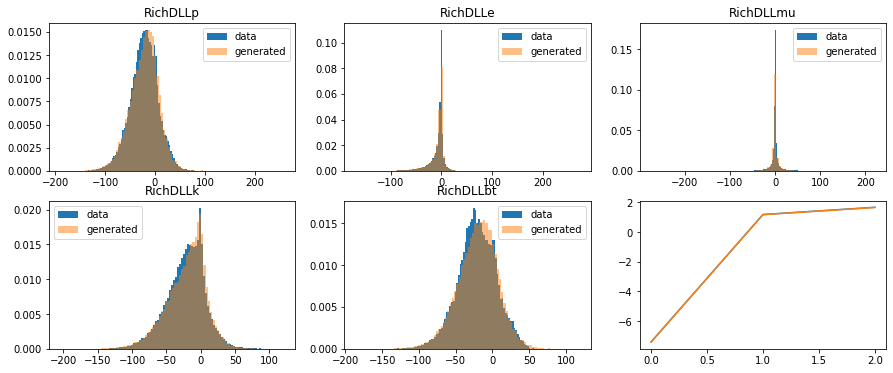

KeyboardInterrupt: 

In [32]:
epoches = 100000
n_samples = 50000
for i in range(step_freq * len(metrics_ll_train), epoches):
    model.train()
    optimizer.zero_grad()
    Y_batch, X_batch = next(data_gen)
    z, logp_z, log_det = model(Y_batch, X_batch)
    logp_x = logp_z + log_det
    loss = -torch.mean(logp_x)
    loss.backward()
#     torch.nn.utils.clip_grad_value_(model.parameters(), 10.0)
    optimizer.step()

    if i % step_freq == 0:
        model.eval()
        with torch.no_grad():
            metrics_ll_train.append(torch.mean(
                model.log_prob(Y_train_tensor[:n_samples], X_train_tensor[:n_samples])
            ).item())
            metrics_ll_test.append(torch.mean(
                model.log_prob(Y_test_tensor[:n_samples], X_test_tensor[:n_samples])
            ).item())
            
            samples = model.sample(
                X_test_tensor[:n_samples],
                batch_size=n_samples,
                post_map=preprocessor.y_scaler.inverse_transform
            )
        
        if metrics_ll_train[-1] > best_loss:
            best_loss = metrics_ll_train[-1]
            torch.save(model.state_dict(), f'model_densnet_10_without_clip/best_model')
            torch.save(optimizer.state_dict(), f'model_densnet_10_without_clip/best_optim')

        clear_output(True)
        print(np.mean(metrics_ll_train[-10:]))
        fig, axs = plt.subplots(2, 3, figsize=(15, 6))
        
        axs[1, 2].plot(metrics_ll_train)
        axs[1, 2].plot(metrics_ll_test)

        for i in range(dim):
            axs[i // 3, i % 3].hist(Y_val_[:n_samples, i], 100, label="data", density=True)
            axs[i // 3, i % 3].hist(samples[:, i], 100, label="generated", density=True, alpha=0.5)
            axs[i // 3, i % 3].legend()
            axs[i // 3, i % 3].set_title(dlls[i])
        
        plt.show()

In [ ]:
! ls model_densnet_10_without_clip

In [18]:
model.load_state_dict(torch.load('model_densnet_10_without_clip/best_model'))

<All keys matched successfully>

In [41]:
samples = model.sample(
    X_test_tensor,
    post_map=preprocessor.y_scaler.inverse_transform
)

d1 = pd.DataFrame(np.hstack([Y_val_, X_val, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([samples, X_val, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsReal'] = True
d2['IsReal'] = False
d2.head()

/home/user/miniconda3/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
0,-9.321677,-1.673072,-0.604068,-12.480613,-8.731994,0.294982,1.030644,2.099587,-0.386506,False
1,-45.329620,-3.299861,-0.144077,-52.810688,-43.512619,0.163298,-0.426636,-0.070372,1.230540,False
2,-77.397408,-11.672708,-1.893643,-82.776520,-79.251175,-0.262142,-0.970473,-0.820032,1.227350,False
3,-11.910617,-42.144604,-25.254025,-11.798086,-12.074571,-1.573248,-0.529054,-0.048686,-0.361230,False
4,-37.905224,-0.798301,-0.268941,-15.193883,-11.830576,1.108002,-0.382148,-0.615571,0.488718,False


In [42]:
def plot_joint_dll_distributions(data, dlls):
    fig, axs = plt.subplots(len(dlls), len(dlls), figsize=(17, 15))#, sharex=True, sharey=True)

    for j, dll1 in enumerate(dlls):
        for i, dll2 in enumerate(dlls):
            q1_1, q1_99 = data[dll1].quantile(0.03), data[dll1].quantile(0.97)
            q2_1, q2_99 = data[dll2].quantile(0.03), data[dll2].quantile(0.97)

            if i == j:
                arr = data[[dll1]].query(f'{q1_1} < {dll1} < {q1_99}')
                axs[i, i].hist(arr[dll1], 100)
                axs[i, i].set_title(dll1)
            else:
                arr = data[[dll1, dll2]] \
                    .query(f'{q1_1} < {dll1} < {q1_99}') \
                    .query(f'{q2_1} < {dll2} < {q2_99}')

                axs[i, j].hist2d(arr[dll1], arr[dll2], (100, 100, ))
                m1, m2 = max(q1_1, q2_1), min(q1_99, q2_99)
                axs[i, j].plot(np.arange(m1, m2, 1), np.arange(m1, m2, 1), c='red')
                axs[i, j].set_title(dll1 + ' ' + dll2)

## Original data distributions

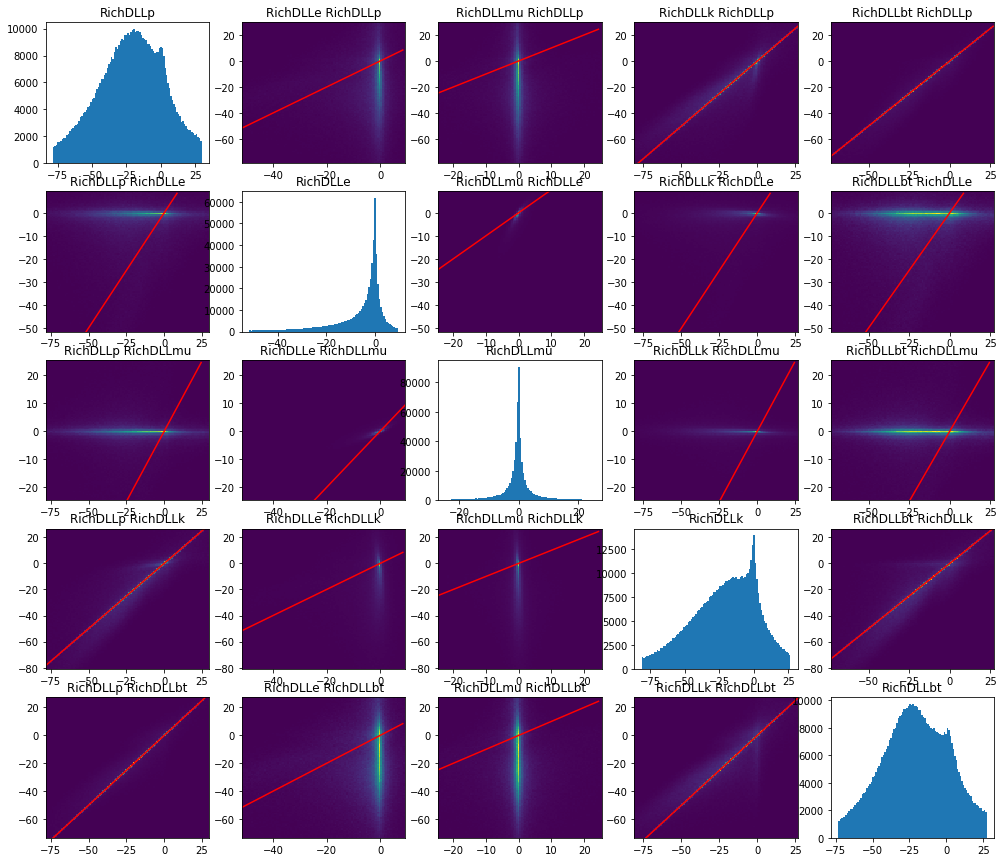

In [43]:
plot_joint_dll_distributions(d1, dlls)

## Generated data distributions

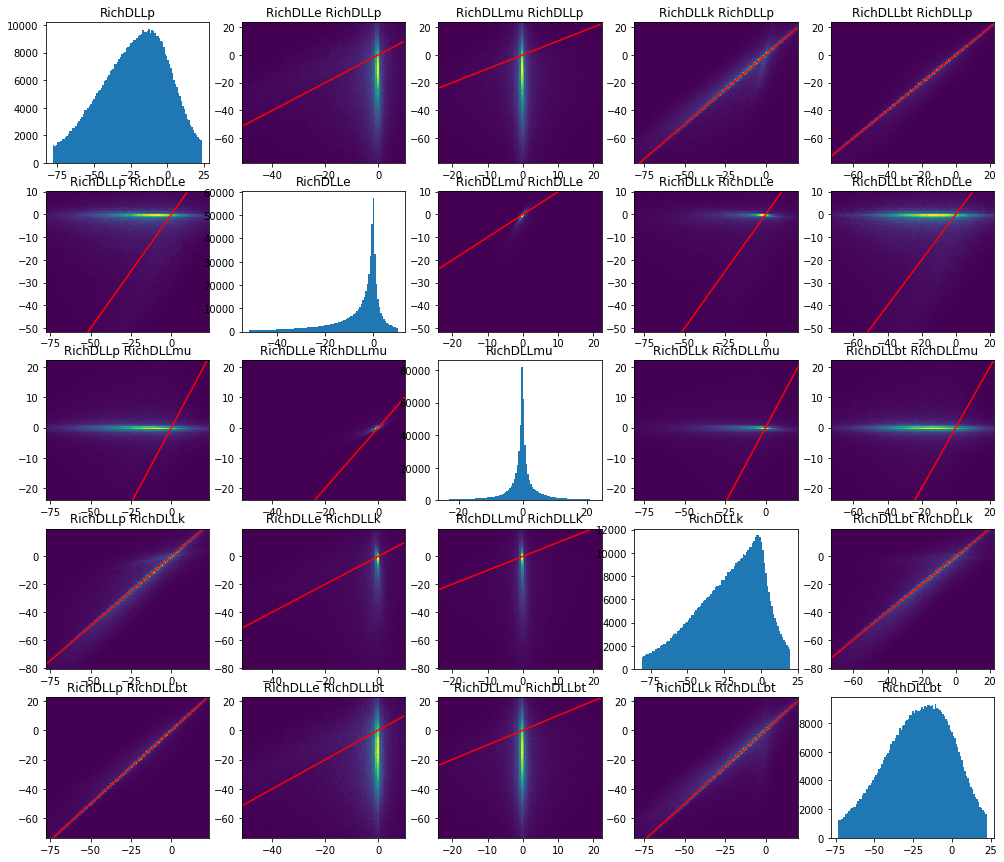

In [44]:
plot_joint_dll_distributions(d2, dlls)

In [45]:
def plot_joint_cond_dll_distributions(data, dll, features):
    fig, axs = plt.subplots(len(dlls) + 1, len(features), figsize=(17, 17))

    for j, f in enumerate(features):
        for i, dll in enumerate([None] + dlls):
            q2_1, q2_99 = data[f].quantile(0.03), data[f].quantile(0.97)
            if i == 0:
                arr = data[[f]].query(f'{q2_1} < {f} < {q2_99}')
                axs[i, j].hist(arr[f], 500)
                axs[i, j].set_title(f)
            else:
                q1_1, q1_99 = data[dll].quantile(0.03), data[dll].quantile(0.97)        

                arr = data[[dll, f]] \
                    .query(f'{q1_1} < {dll} < {q1_99}') \
                    .query(f'{q2_1} < {f} < {q2_99}')

                axs[i, j].hist2d(arr[f], arr[dll], (100, 100, ))
                axs[i, j].set_title(f + ' ' + dll)

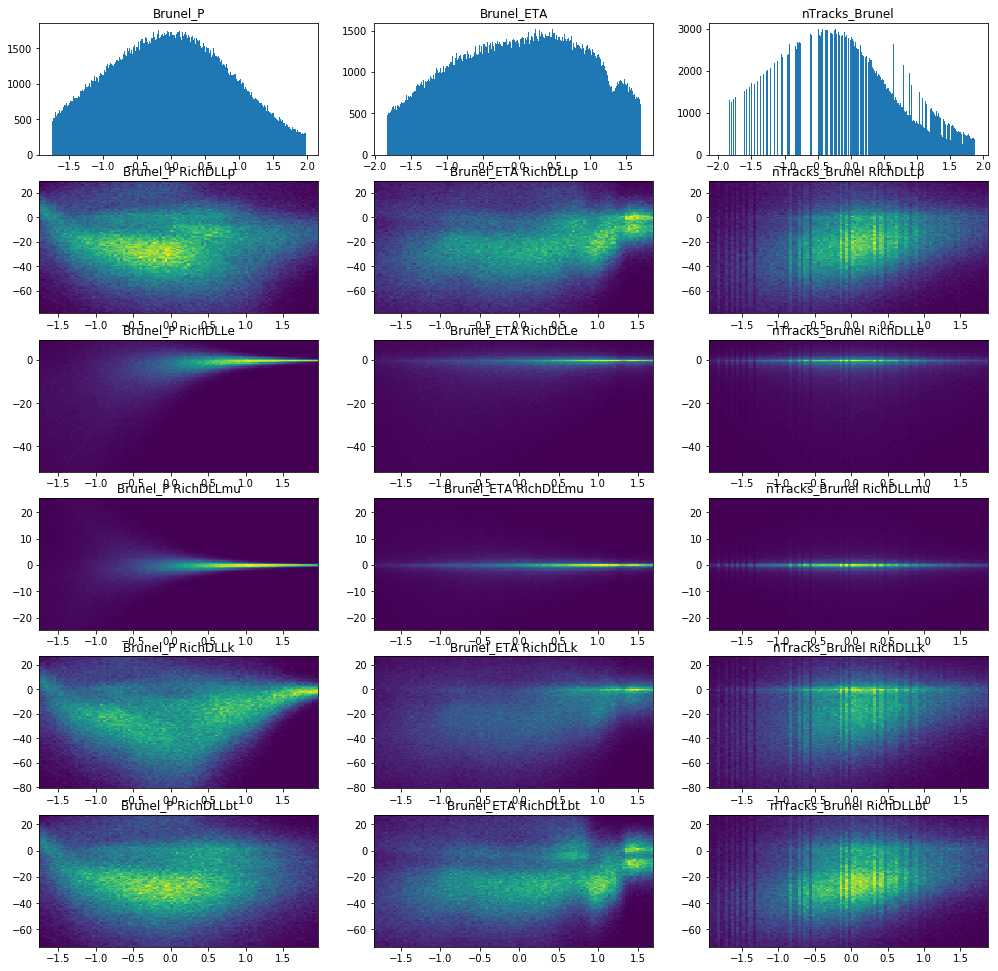

In [46]:
plot_joint_cond_dll_distributions(d1, dlls, features)

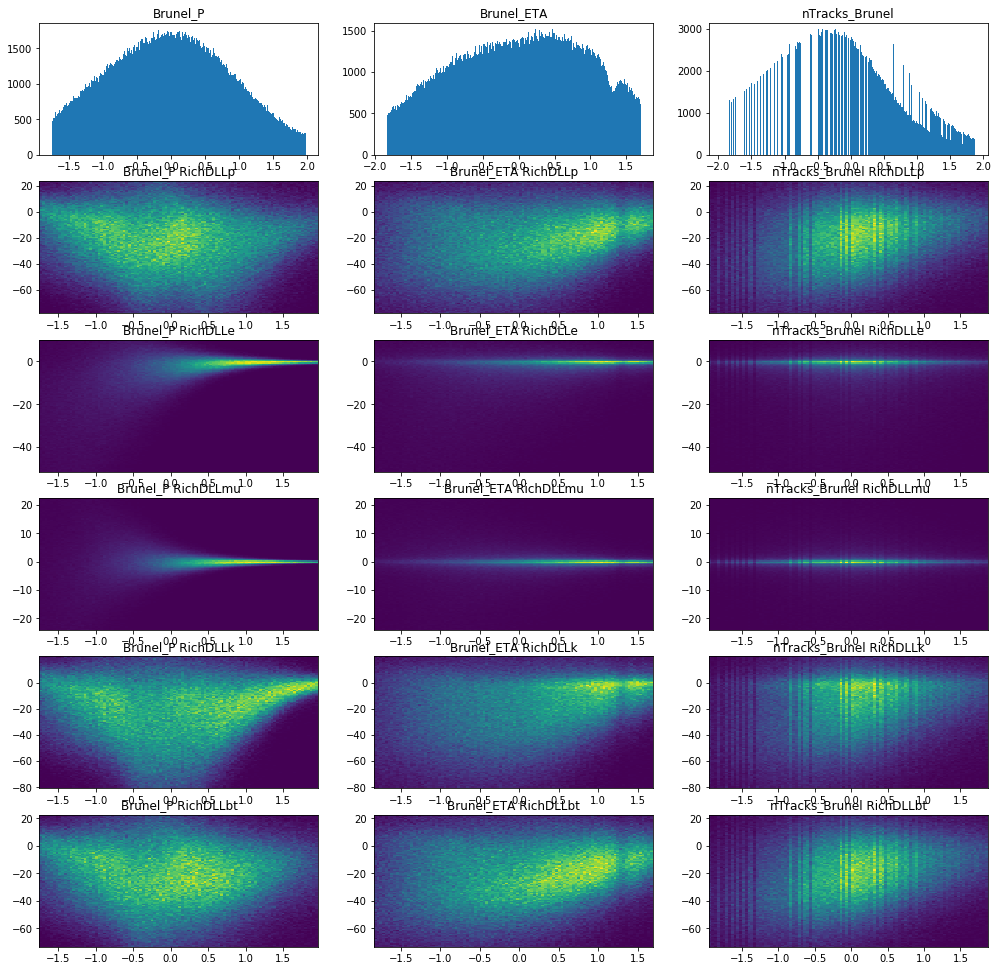

In [47]:
plot_joint_cond_dll_distributions(d2, dlls, features)

In [48]:
classification_ds = pd.concat([d1, d2]).sample(frac=1)
classification_ds.head(10)

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
320315,-59.372101,-1.033960,-0.274266,-49.284401,-44.846600,0.401159,-1.216478,-0.786996,1.110800,True
515755,-16.260826,1.735478,1.238060,-9.243360,-19.917343,0.364921,1.440176,-0.586113,1.261940,False
310488,2.667545,-1.277590,-0.096360,-3.380692,2.594662,-0.078002,0.322037,-0.836785,-0.116440,False
108073,-9.022332,-30.087252,45.329243,-9.287301,-9.471338,-1.232231,-1.434617,-0.070372,1.247180,False
170445,-44.537300,-2.942510,-1.150890,-74.626701,-35.061100,0.155820,-1.537636,-1.455194,-0.195463,True
39223,-22.814674,-14.412756,-6.330635,-29.267582,-22.889366,-0.549340,-0.817509,2.192958,1.208900,False
92485,69.085701,-0.969154,-0.604698,12.486600,37.657101,1.130604,0.617160,-1.630826,-0.389484,True
415857,-58.401402,-4.279570,-0.941627,-66.597504,-55.276402,0.024395,-1.542417,0.405044,1.025400,True
319794,5.003640,0.668990,0.656416,0.230367,-1.022080,0.466505,1.001263,1.408349,0.377183,True
222574,-5.081270,1.872080,0.831063,-18.913601,-14.659500,0.493707,1.023149,-3.237148,-0.386437,True


In [49]:
n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]
cls_train.shape, cls_val.shape

((833368, 10), (357158, 10))

In [52]:
xgb_model = xgb.XGBClassifier(**params)

In [54]:
xgb_model.fit(
    X=cls_train[dlls + features].values,
    y=cls_train['IsReal'].values.astype('int32'),
)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=24, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [58]:
is_gen_pred = xgb_model.predict(cls_val[dlls + features].values)
is_gen_pred_probas = xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1]
is_gen_true = cls_val['IsReal'].values
cls_weights = cls_val[weight_filed].values

In [61]:
print('Accuracy =', np.sum(is_gen_pred == is_gen_true) / len(is_gen_pred))
print('ROC AUC =', roc_auc_score(is_gen_true, is_gen_pred_probas))
print('Weighted AUC ROC =', my_roc_auc(is_gen_true, xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1], cls_weights))

Accuracy = 0.6168670448372989
ROC AUC = 0.6708213494116443
Weighted AUC ROC = 0.654779590960561


In [63]:
samples = model.sample(
    X_train_tensor,
    post_map=preprocessor.y_scaler.inverse_transform
)
d1 = pd.DataFrame(np.hstack([Y_train_, X_train, w_train.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([samples, X_train, w_train.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsReal'] = True
d2['IsReal'] = False

classification_ds = pd.concat([d1, d2]).sample(frac=1)

n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]

cls_train.head(10)

/home/user/miniconda3/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
1167822,2.488567,-0.964561,-2.094171,6.006949,2.193289,-0.454107,0.281609,1.583661,-0.088373,False
661789,-3.522638,1.421984,1.709136,-5.563788,-7.330261,0.468664,0.779877,0.799430,-0.397884,False
1203950,-10.069743,-2.059751,0.393785,-17.871771,-8.795428,0.076781,0.840708,-0.059496,-0.392650,False
715359,-18.351667,13.443374,7.495755,-18.030373,-18.210398,-0.635462,-1.228969,1.024564,-0.368425,False
83115,-43.236263,-1.138240,-0.399781,-28.457979,-23.988565,1.195846,0.176772,-0.820032,1.248950,False
1313334,-60.453072,0.241694,-0.637277,-14.785899,-40.252316,0.613351,-1.542347,0.220680,-0.380025,False
1295849,-18.902901,-4.661600,0.344427,-24.515600,-18.902901,-0.561102,-0.867088,2.093183,-0.388019,True
1034371,-59.979755,-3.905117,0.049955,-72.962715,-56.055733,0.456445,-0.005434,0.337058,-0.377627,False
501637,-10.829100,6.554240,13.026200,-11.172400,-10.829100,-0.721894,-0.348656,1.065195,-0.035498,True
22180,3.903278,-3.031467,-0.975541,-7.090857,4.129601,-0.004592,0.323192,0.594591,-0.356347,False


In [64]:
clf = CatBoostClassifier(
    1000, eval_metric='AUC',
    metric_period=100,
    use_best_model=False
).fit(
    cls_train[dlls + features].values,
    cls_train['IsReal'].values.astype('int32'),
    eval_set=(
        cls_val[dlls + features].values,
        cls_val['IsReal'].values.astype('int32'),
    )
)

Learning rate set to 0.261371
0:	test: 0.5408044	best: 0.5408044 (0)	total: 274ms	remaining: 4m 33s
100:	test: 0.6730943	best: 0.6730943 (100)	total: 13s	remaining: 1m 55s
200:	test: 0.7162997	best: 0.7162997 (200)	total: 26.1s	remaining: 1m 43s
300:	test: 0.7430909	best: 0.7430909 (300)	total: 38.8s	remaining: 1m 30s
400:	test: 0.7674800	best: 0.7674800 (400)	total: 51.5s	remaining: 1m 16s
500:	test: 0.7895438	best: 0.7895438 (500)	total: 1m 4s	remaining: 1m 4s
600:	test: 0.8008514	best: 0.8008514 (600)	total: 1m 17s	remaining: 51.6s
700:	test: 0.8085941	best: 0.8085941 (700)	total: 1m 30s	remaining: 38.6s
800:	test: 0.8160265	best: 0.8160265 (800)	total: 1m 43s	remaining: 25.8s
900:	test: 0.8224244	best: 0.8224244 (900)	total: 1m 56s	remaining: 12.8s
999:	test: 0.8259465	best: 0.8259465 (999)	total: 2m 9s	remaining: 0us

bestTest = 0.8259465054
bestIteration = 999



In [65]:
preds = clf.predict(cls_train[dlls + features], prediction_type='RawFormulaVal')

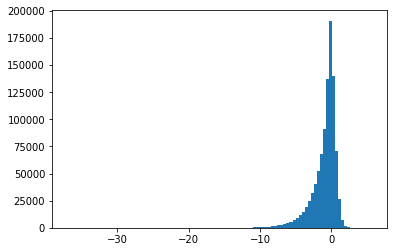

In [69]:
plt.hist(preds[~cls_train['IsReal'].values], bins=100);

In [70]:
clf_wrapper = lambda x: np.clip(clf.predict(x, prediction_type='RawFormulaVal'), -100, np.log(2))

In [74]:
def rejection_sampling(clf, maj_dist, c, condition, post_map):
    need_sample = np.ones(len(condition), dtype=np.bool)
    samples = np.empty((len(condition), maj_dist.dim, ))
    np_cond = condition.detach().cpu().numpy()
    while True:
        idxs = np.where(need_sample)[0]
        if len(idxs) == 0:
            break
        samples_ = maj_dist.sample(condition[idxs], post_map=post_map)
        accept_log_prob = clf(np.hstack([samples_, np_cond[idxs]])) - np.log(c)
        is_accept = (accept_log_prob > np.log(np.random.uniform(0, 1, len(idxs))))
        need_sample[idxs[is_accept]] = False
        samples[idxs[is_accept]] = samples_[is_accept]
    return samples

In [75]:
samples = rejection_sampling(clf_wrapper, model, 2, X_train_tensor, preprocessor.y_scaler.inverse_transform)
d1 = pd.DataFrame(np.hstack([Y_train_, X_train, w_train.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([samples, X_train, w_train.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsReal'] = True
d2['IsReal'] = False

n = d1.shape[0]
classification_ds = pd.concat([d1, d2]).sample(frac=1)

n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]

cls_train.head(10)

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
699411,-12.374100,-22.025999,1.565380,-12.374100,-12.374100,-1.363872,0.189256,0.946533,-0.387771,True
1034037,-40.729401,2.528310,2.520050,-45.734001,-40.729401,-0.240571,-0.289924,0.667938,-0.386417,True
1150111,31.753876,0.008146,-0.864247,15.309154,17.810621,0.271224,-0.241650,-0.923017,-0.399572,False
558622,-24.153200,-10.487300,28.237000,-24.153200,-24.153200,-1.391371,-1.522533,-0.341002,0.306144,True
1317609,43.581402,2.120740,0.197826,9.168470,32.301201,0.240041,-0.175107,-0.103409,-0.352527,True
1302336,-17.512569,-0.005521,2.234810,-22.675333,-17.630598,-0.373002,-0.401779,-0.278543,0.862904,False
1215782,-52.982903,7.916941,19.378826,-53.674690,-53.182022,-0.870994,-2.025372,0.220680,1.265730,False
1035811,-1.759903,-0.792073,-0.138632,3.748826,-4.139889,1.075454,1.247763,-0.081316,1.079040,False
273643,13.375244,-15.774144,97.365562,13.380767,13.610060,-2.076721,-1.847787,0.345700,-0.371286,False
1037758,-26.330778,-12.387825,10.890781,-27.249653,-26.334766,-0.793661,-0.656033,-0.103409,1.241330,False


In [76]:
xgb_model = xgb.XGBClassifier(**params)

xgb_model.fit(
    X=cls_train[dlls + features].values,
    y=cls_train['IsReal'].values.astype('int32'),
#     sample_weight=cls_train[weight_filed]
)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=24, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [77]:
is_gen_pred = xgb_model.predict(cls_val[dlls + features].values)
is_gen_pred_probas = xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1]
is_gen_true = cls_val['IsReal'].values
cls_weights = cls_val[weight_filed].values

print('Accuracy =', np.sum(is_gen_pred == is_gen_true) / len(is_gen_pred))
print('ROC AUC =', roc_auc_score(is_gen_true, is_gen_pred_probas))
print('Weighted AUC ROC =', my_roc_auc(is_gen_true, xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1], cls_weights))

Accuracy = 0.5628077871960526
ROC AUC = 0.5997248569393139
Weighted AUC ROC = 0.5739538056429462


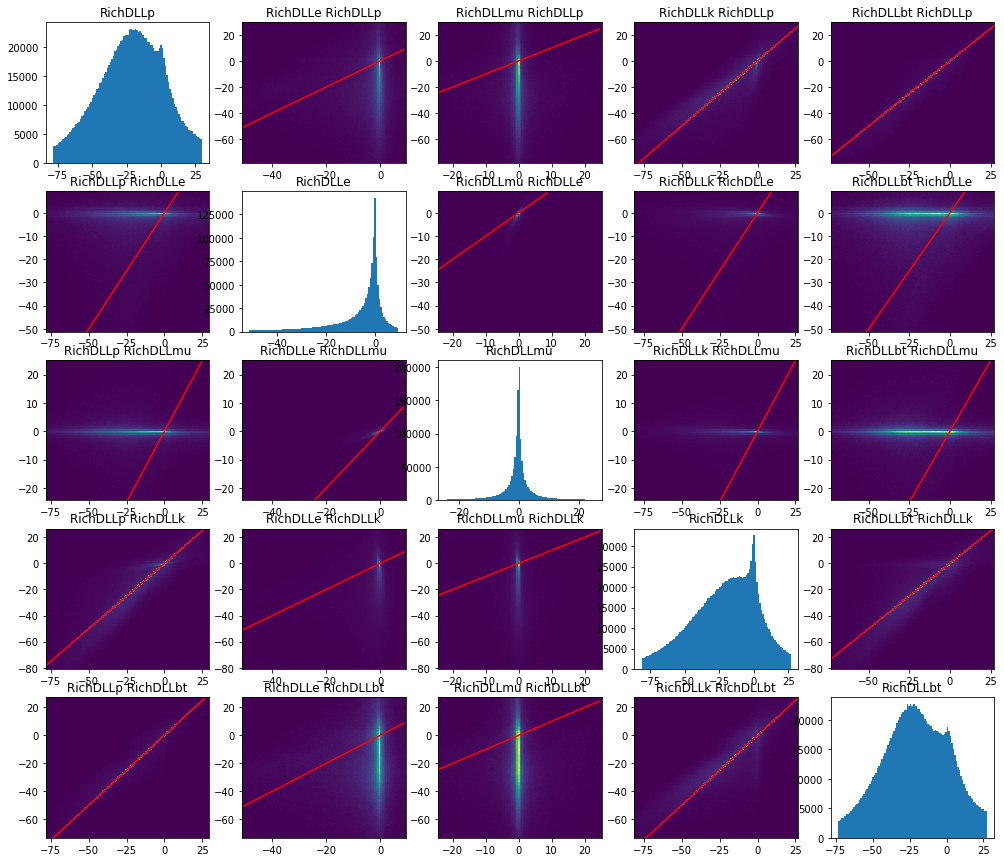

In [78]:
plot_joint_dll_distributions(d1, dlls)

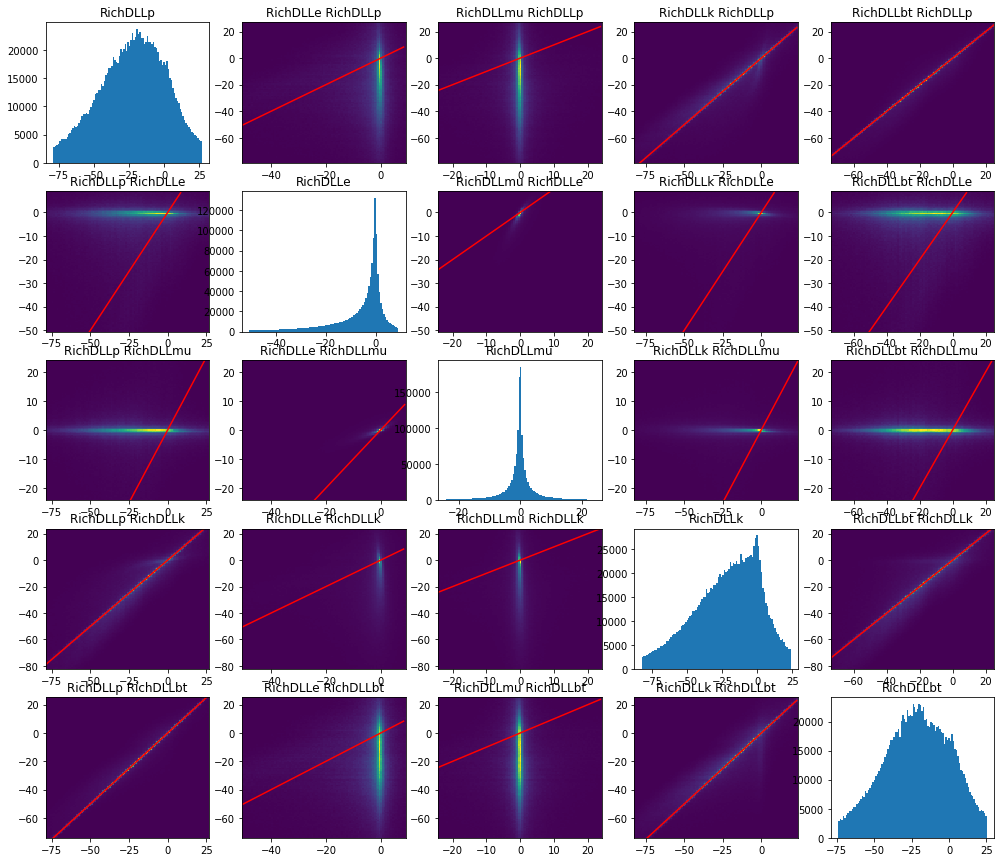

In [79]:
plot_joint_dll_distributions(d2, dlls)

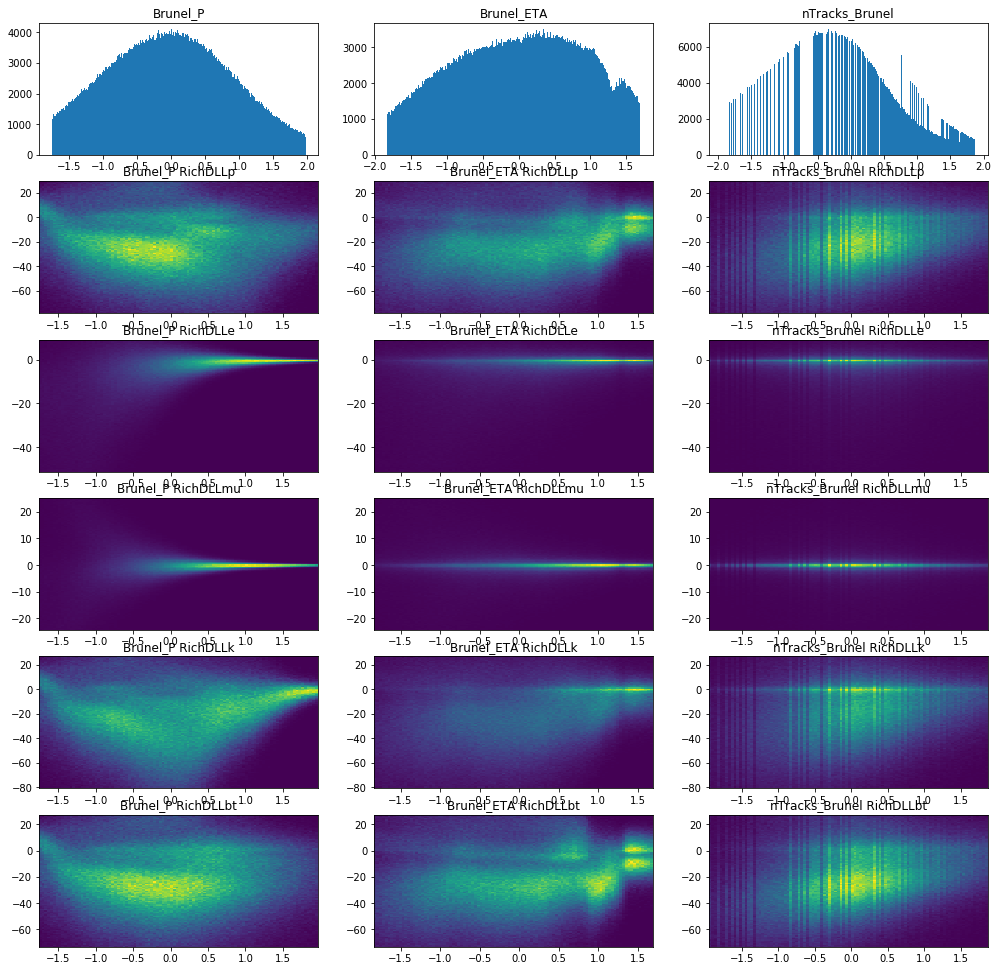

In [80]:
plot_joint_cond_dll_distributions(d1, dlls, features)

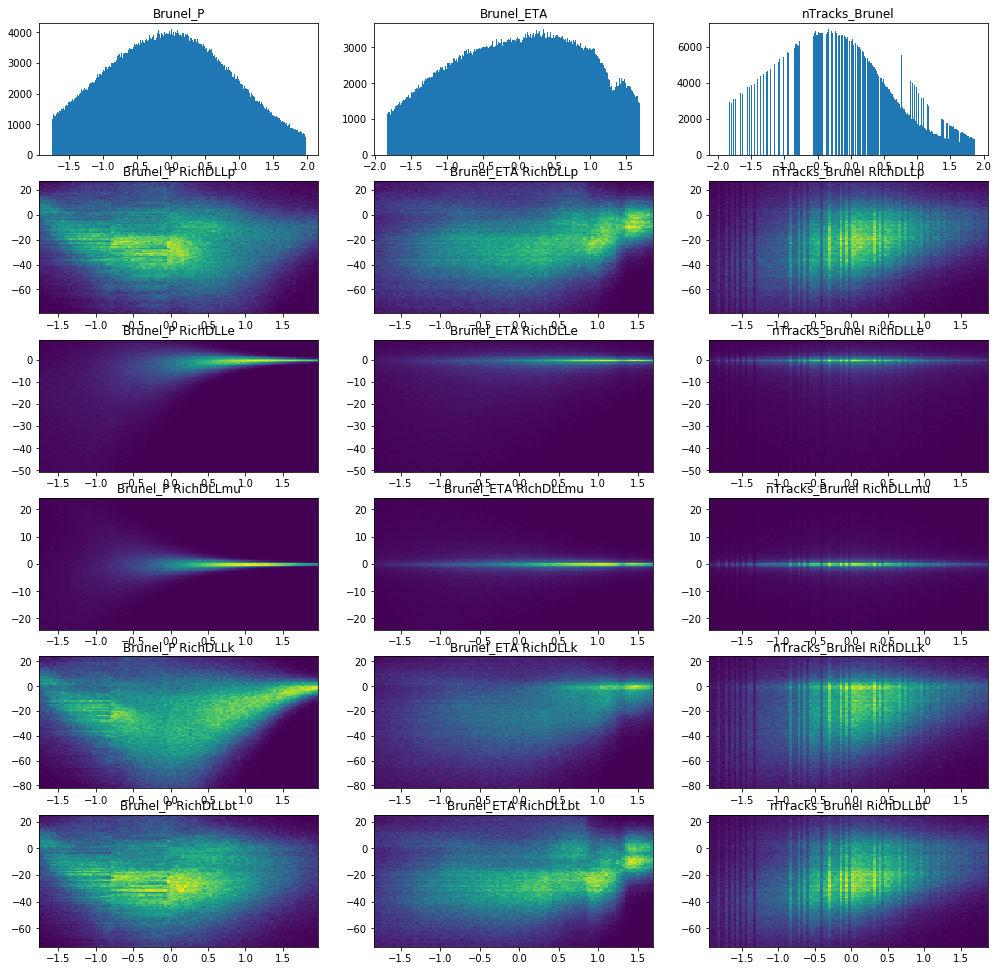

In [81]:
plot_joint_cond_dll_distributions(d2, dlls, features)